In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from depth_rebasing.Md import Md, normalize
import os
import pandas as pd
import pickle
import glob
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [24]:
#!pip install face_alignment

In [7]:
import face_alignment
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import collections
# Optionally set detector and some additional detector parameters
face_detector = 'sfd'
face_detector_kwargs = {
    "filter_threshold" : 0.8
}
#you can change device to 'gpu'

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True,
                                  face_detector=face_detector, face_detector_kwargs=face_detector_kwargs)

from face_alignment_eyes import bulat_al

AttributeError: module 'face_alignment' has no attribute 'FaceAlignment'

(385, 300, 3)
224 224


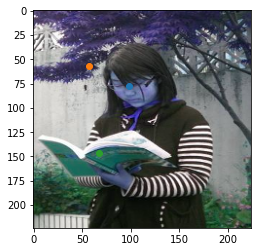

In [2]:
img= cv.imread("C:/Users/Admin/Documents/UPMC_ISI_2/ML/data/train/00000003/00003018.jpg")
print(img.shape)
img=cv.resize(img, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
plt.imshow(img)

x,y,c=img.shape
print(x,y)

# point entre les yeux bleu
xg=int(0.44*y)
yg=int(0.34416*x)
plt.scatter(xg,yg)

#target vert
xtr=int(0.30333*y)
ytr=int(0.65325*x)

# sommet gauche orange
plt.scatter(57,57)
plt.scatter(xtr,ytr)
#0.17, 0.08,,0.29091,0.20713,  0.14727,0.63984
#0.19,0.15,0.44,0.34416,0.30333,0.65325

In [119]:
# x1
x1=int(y*0.19)
print(x1)
#y1
y1=int(x*0.15)
print(y1)


57
57


In [120]:
imgg=img[y1:y1+(yg-y1)*2,x1:x1+(xg-x1)*2]

(150, 150, 3)


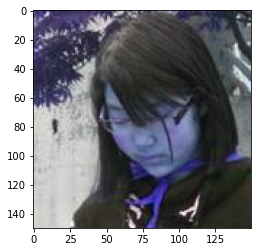

In [179]:
plt.imshow(imgg)
print(np.shape(imgg))

In [158]:
# extract head image
def extract_head(img, xi,yi,xg,yg):
    x,y= np.shape(img)[0:2] # height and width of image
    
    # point entre les yeux
    xg=int(xg*y)
    yg=int(yg*x)
    
    #point sommet gauche
    xi=int(y*xi)
    yi=int(x*yi)
    
    head=img[yi:yi+(yg-yi)*2,xi:xi+(xg-xi)*2]
    return head

def extract_target(img,xtr,ytr):
    x,y = np.shape(img)[0:2] 
    target=[int(ytr*x),int(xtr*y)]  # correspondent aux coordonnées x, sur l'image python
    return target

(138, 100, 3)


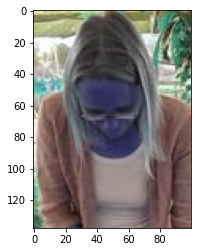

In [214]:
hd= extract_head(imgs[0][1],0.34,0.02,0.50667,0.1925)
plt.imshow(hd)
print(np.shape(hd))

tr=

In [227]:
ll=[]
ll.append(hd)
ll.append(cv.resize(imgg, dsize=(224, 224), interpolation=cv.INTER_CUBIC))

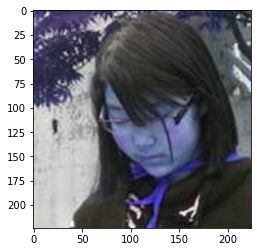

In [228]:
plt.imshow(ll[1])

In [151]:
def load_images_from_folder(folder,i):
    images = []
    img_path = []
    
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            #img_path.append(folder +"/" +filename)
            img_path.append('train/0000000'+ str(i)+"/" +filename)            
        
    return images, img_path

In [115]:
path_base_data="C:/Users/Admin/Documents/UPMC_ISI_2/ML/data/train" # database path
path_annotation="C:/Users/Admin/Documents/UPMC_ISI_2/ML/data/train_annotations.txt" #annotation path
directories=[x[0] for x in os.walk(path_base_data)] # list of different directories in database

In [310]:
# base de donnée de test pour gaze estimation --> determiner alors gx,gy,gz, 
imgs=[]
imgs_heads=[]
imgs_right_eye=[] 
imgs_left_eye=[] 
imgs_target=[]
imgs_name=[]
imgs_path=[]


In [311]:
# for all images
def get_images(directories):
    imgs=[]
    imgs_path=[]
    for i in range (4): 
        #print(directories[i+1])
        img, img_path =load_images_from_folder(directories[i+1],i+1)

        imgs.append(img)
        imgs_path.append(img_path)
       
    return imgs, imgs_path

imgs,imgs_path=get_images(directories) 

KeyboardInterrupt: 

In [241]:
# get information from the txt file
def get_annotation(path_annotation):
    with open(path_annotation, 'r') as f:
        annotations = [[num for num in line.split(',')] for line in f]
    f.close()
    annotations = np.array(annotations)
    return annotations

In [245]:
# build the head data, get target position , extract left and right eye 
def create_data(imgs, imgs_path, imgs_heads, imgs_target, imgs_right_eye, imgs_left_eye, annotations):
    for i in range (np.size(imgs)):    
        l=0
        target=np.zeros((np.shape(imgs)[0],2))
        #annot = "C:/Users/Admin/Documents/UPMC_ISI_2/ML/data/"
        #print(imgs_path[0][i])
        for k in annotations[:,0]:        
            #k=annot+k
            
            if k==imgs_path[0][i]:
                print(k)
                img= extract_head(imgs[0][i],float(annotations[l,2]),float(annotations[l,3]),float(annotations[l,6]),float(annotations[l,7]))           
                target=extract_target(imgs[0][i],float(annotations[l,8]),float(annotations[l,9]))   
                # eye extraction
                #imEye_l,imEye_r= bulat_al(img,fa)
                
                imgs_heads.append(cv.resize(img, dsize=(224, 224), interpolation=cv.INTER_CUBIC))  #vecteur ligne
                imgs_target.append(target) #vecteur ligne
                #imgs_right_eye.append(imEye_r)
                #imgs_left_eye.append(imEye_l)
                
            l=l+1
        imgs[0][i]=cv.resize(imgs[0][i], dsize=(224, 224), interpolation=cv.INTER_CUBIC)
    return imgs, imgs_heads, imgs_target, imgs_right_eye, imgs_left_eye
    

In [246]:
# gaze follow data
annotations = get_annotation(path_annotation)
imgs, imgs_heads, imgs_target, imgs_right_eye, imgs_left_eye = create_data(imgs, imgs_path, imgs_heads, imgs_target, imgs_right_eye, imgs_left_eye, annotations)

train/00000001/00001000.jpg
train/00000001/00001001.jpg
train/00000001/00001002.jpg
train/00000001/00001003.jpg
train/00000001/00001004.jpg
train/00000001/00001005.jpg
train/00000001/00001006.jpg
train/00000001/00001007.jpg
train/00000001/00001008.jpg
train/00000001/00001009.jpg
train/00000001/00001010.jpg
train/00000001/00001011.jpg
train/00000001/00001012.jpg
train/00000001/00001013.jpg
train/00000001/00001014.jpg
train/00000001/00001015.jpg
train/00000001/00001016.jpg
train/00000001/00001017.jpg
train/00000001/00001018.jpg
train/00000001/00001019.jpg
train/00000001/00001020.jpg
train/00000001/00001021.jpg
train/00000001/00001022.jpg
train/00000001/00001023.jpg
train/00000001/00001024.jpg
train/00000001/00001025.jpg
train/00000001/00001026.jpg
train/00000001/00001027.jpg
train/00000001/00001028.jpg
train/00000001/00001029.jpg
train/00000001/00001030.jpg
train/00000001/00001031.jpg
train/00000001/00001032.jpg
train/00000001/00001033.jpg
train/00000001/00001034.jpg
train/00000001/00001

train/00000001/00001293.jpg
train/00000001/00001294.jpg
train/00000001/00001295.jpg
train/00000001/00001296.jpg
train/00000001/00001297.jpg
train/00000001/00001298.jpg
train/00000001/00001299.jpg
train/00000001/00001300.jpg
train/00000001/00001301.jpg
train/00000001/00001302.jpg
train/00000001/00001303.jpg
train/00000001/00001304.jpg
train/00000001/00001305.jpg
train/00000001/00001306.jpg
train/00000001/00001307.jpg
train/00000001/00001308.jpg
train/00000001/00001309.jpg
train/00000001/00001310.jpg
train/00000001/00001311.jpg
train/00000001/00001312.jpg
train/00000001/00001313.jpg
train/00000001/00001314.jpg
train/00000001/00001315.jpg
train/00000001/00001316.jpg
train/00000001/00001317.jpg
train/00000001/00001318.jpg
train/00000001/00001319.jpg
train/00000001/00001320.jpg
train/00000001/00001321.jpg
train/00000001/00001322.jpg
train/00000001/00001323.jpg
train/00000001/00001324.jpg
train/00000001/00001325.jpg
train/00000001/00001326.jpg
train/00000001/00001327.jpg
train/00000001/00001

train/00000001/00001587.jpg
train/00000001/00001588.jpg
train/00000001/00001589.jpg
train/00000001/00001590.jpg
train/00000001/00001591.jpg
train/00000001/00001592.jpg
train/00000001/00001593.jpg
train/00000001/00001594.jpg
train/00000001/00001595.jpg
train/00000001/00001596.jpg
train/00000001/00001597.jpg
train/00000001/00001598.jpg
train/00000001/00001599.jpg
train/00000001/00001600.jpg
train/00000001/00001601.jpg
train/00000001/00001602.jpg
train/00000001/00001603.jpg
train/00000001/00001604.jpg
train/00000001/00001605.jpg
train/00000001/00001606.jpg
train/00000001/00001607.jpg
train/00000001/00001608.jpg
train/00000001/00001609.jpg
train/00000001/00001610.jpg
train/00000001/00001611.jpg
train/00000001/00001612.jpg
train/00000001/00001613.jpg
train/00000001/00001614.jpg
train/00000001/00001615.jpg
train/00000001/00001616.jpg
train/00000001/00001617.jpg
train/00000001/00001618.jpg
train/00000001/00001619.jpg
train/00000001/00001620.jpg
train/00000001/00001621.jpg
train/00000001/00001

train/00000001/00001879.jpg
train/00000001/00001880.jpg
train/00000001/00001881.jpg
train/00000001/00001882.jpg
train/00000001/00001883.jpg
train/00000001/00001884.jpg
train/00000001/00001885.jpg
train/00000001/00001886.jpg
train/00000001/00001887.jpg
train/00000001/00001888.jpg
train/00000001/00001889.jpg
train/00000001/00001890.jpg
train/00000001/00001891.jpg
train/00000001/00001892.jpg
train/00000001/00001893.jpg
train/00000001/00001894.jpg
train/00000001/00001895.jpg
train/00000001/00001896.jpg
train/00000001/00001897.jpg
train/00000001/00001898.jpg
train/00000001/00001899.jpg
train/00000001/00001900.jpg
train/00000001/00001901.jpg
train/00000001/00001902.jpg
train/00000001/00001903.jpg
train/00000001/00001904.jpg
train/00000001/00001905.jpg
train/00000001/00001906.jpg
train/00000001/00001907.jpg
train/00000001/00001908.jpg
train/00000001/00001909.jpg
train/00000001/00001910.jpg
train/00000001/00001911.jpg
train/00000001/00001912.jpg
train/00000001/00001913.jpg
train/00000001/00001

In [309]:
imgs_heads=imgs_heads[1:]

(999, 224, 224, 3)


In [300]:
# save images to input file for depth estimation
path_depth_estimation_input='C:/Users/Admin/Documents/UPMC_ISI_2/ML/projet/Dual-Attention-Guided-Gaze-Target-Detection-in-the-Wild/depth_estimation/input/'
for i in range (3):#(np.size(imgs)): 
    ig = cv.imread("C:/Users/Admin/Documents/UPMC_ISI_2/ML/data/" + imgs_path[0][i])   
   
    cv.imwrite(path_depth_estimation_input + str(i)+".jpg", ig)

In [303]:
# create the pickle file
with open('imgs_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs, f)   


In [302]:
#depth estimation using midas_small
%run "depth_estimation\run.py"

# recuperer les depth map du output folder
depth_maps=[] 
path_output= 'C:/Users/Admin/Documents/UPMC_ISI_2/ML/projet/Dual-Attention-Guided-Gaze-Target-Detection-in-the-Wild/depth_estimation/output'
# see code depth estimation

initialize
device: cpu
Loading weights:  depth_estimation/weights/midas_v21_small-70d6b9c8.pt


Using cache found in C:\Users\Admin/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


start processing
finished


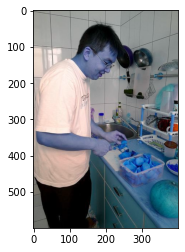

In [56]:
# build the heatmaps
def DAM(depth_maps, FOV_maps,imgs_heads, gz):
    for i in range (np.size(depth_maps)):    
        heat_maps=Md(depth_maps[i], imgs_heads[i], gz[i]) # on doit multiplier par le module FOV
    
    return heat_maps


In [ ]:
heat_maps_tr=[] # determiner la heatmap de chaque image de test
gz_tr=[] # information to get from gaze detection

In [ ]:
# build the dataset for classification
# x_train = imgs, heat_maps
# y_train = find maxpoint and draw a circle

In [ ]:
# à faire:
# estimer l'emplacement des yeux pr gaze_follow
# entrainer gaze360 et tester sur gaze follow , recuperer gx,gy,gz
# determiner alors les heat_maps 
# entrainer la partie 3

In [37]:
x=[[1,2,1]]
print(x[0][1])

2
